Author: Aeon Williams

December 2020

# RCNN
Object detection in photos with variable number of classes and objects per photo.

In [1]:
# Jupyter Q.O.L tools by Aeon Williams
from bae0n_utils import * # ActivateCellFailSound, FitCellsToWindow,
                          # ColoredText, ActivateCellDoneSound, ClearDir
#ActivateCellFailSound()
FitCellsToWindow()

In [2]:
import xml.etree.ElementTree as ET # parse, getroot, iter
from sklearn.datasets import load_files
import cv2 # imread, imwrite, selectiveSearchSegmentation, cvtColor, flip, 
           # setBaseImage, switchToSelectiveSearchFast, proces
import os # listdir
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  
import pandas as pd
import tensorflow as tf
import PIL.Image as Image
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense
from keras.optimizers import Adam
from keras.models import load_model
from sklearn.preprocessing import OneHotEncoder
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import StratifiedKFold
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


<hr>

# The Code

In [3]:
class Config:
    """
    Configuration settings for model training.
    
    Attributes:
    -----------
    epochs : int = 100
        Number of epochs to run the model during training
    batchsize : int = 64
        Number of samples per segment of model training
    k_folds : int = 10
        Number of folds for k-fold cross validation
    test_split : float (0-1) = 0.3
        Percentage size of test data
    val_split : float (0-1) = 0.15
        Percentage size of validation data
    image_size : float = 128
        Width & Height of images for the model - must match size used in
        preprocessing
    labels : list of strings = []
        If not empty, these are the only class labels that will be preprocessed
        to use to train the model
    lr : float = 0.0001
        Learning rate of the model
    filename : string = 'model.h5'
        Name of the model to create - must end in .h5
    datapath : string = ''
        Directory to find training data
    patience : int = 10
        Number of epochs to tolerate 0 improvement before early stopping
    es : Bool = True
        Toggle early stopping
    crossvalidate : Bool = False
        Toggle cross validation (if True, runs does not matter)
    runs : int = 1
        Number of times to evaluate model results (does not matter if
        crossvalidate = True)
    savemodel : Bool = False
        Toggle saving the model into a file. filename is only used if this
        is true
    img_type : string = '.jpg'
        Filetype of training images to use
    xml_instance_tag : string = ''
        Tag of instance segment
    xml_instance_file_tag : string = ''
        Tag of instance filename, including type extension
    xml_instance_label_tag : string = ''
        Tag of instance class label
    xml_instance_bndbox_tag : string = None
        If not set to None, this tells the parser where to find bounding
        box coordinates
    xml_instance_sub_object : string = None
        If not set to None, this tells the parser that objects in the
        image are located within sub sections
    """
    def __init__(self, epochs=100, batchsize=64, k_folds=10, test_split=0.3, 
                 val_split=0.15, image_size=128, labels=[], lr=0.0001, 
                 filename='model.h5', datapath='', patience=10, es=True,
                 crossvalidate=False, runs=1, savemodel=False, img_type='.jpg', 
                 xml_instance_tag='row', xml_instance_file_tag='image', 
                 xml_instance_label_tag='label', xml_instance_bndbox_tag=None, 
                 xml_instance_sub_object=None):
        """
        Constructs all attributes for the config data.
        
        Parameters:
            self - Implied "this" parameter
            
            See class attributes above.
        """
        self.xml_instance_sub_object = xml_instance_sub_object
        self.xml_instance_bndbox_tag = xml_instance_bndbox_tag
        self.xml_instance_label_tag = xml_instance_label_tag
        self.xml_instance_file_tag = xml_instance_file_tag
        self.xml_instance_tag = xml_instance_tag
        self.epochs = epochs
        self.batchsize = batchsize
        self.k_folds = k_folds
        self.test_split = test_split
        self.val_split = val_split
        self.image_size = image_size
        self.labels = labels
        self.lr = lr
        self.filename = filename
        self.datapath = datapath
        self.patience = patience
        self.es = es
        self.crossvalidate = crossvalidate
        self.runs = runs
        self.savemodel = savemodel
        self.img_type = img_type

## File I/O

In [4]:
def parse_annotations(xml_file: str, config):
    """
    Reads an XML file of image information.
    
    Parameters:
        xml_file - The name of the xml file to parse
        
    Returns (in order):
        - The name of the image
        - list of lists of boxes [xmin, ymin, xmax, ymax]
        - list of label names that correspond with each box list 
        If xml_file is not found, None is returned for all 3 values.
    """
    try:
        # open the xml file and find the start of the root
        tree = ET.parse(xml_file)
        root = tree.getroot()
        list_with_all_boxes = []
        labels = []
        # each bounding box for an image is stored in "row" chunks
        for rows in root.iter(config.xml_instance_tag):
            # store relevant information
            filename = rows.find(config.xml_instance_file_tag).text
            if config.xml_instance_sub_object != None:
                name = rows.find(xml_instance_sub_object).find(config.xml_instance_label_tag).text
                # quick fix
                if len(config.labels) > 0:
                    if str(name) not in config.labels:
                        continue
                if config.xml_instance_bndbox_tag != None:
                    ymin = int(float(rows.find(xml_instance_bndbox_tag).find('ymin').text))
                    ymax = int(float(rows.find(xml_instance_bndbox_tag).find('ymax').text))
                    xmin = int(float(rows.find(xml_instance_bndbox_tag).find('xmin').text))
                    xmax = int(float(rows.find(xml_instance_bndbox_tag).find('xmax').text))
                else:
                    ymin = int(float(rows.find('ymin').text))
                    ymax = int(float(rows.find('ymax').text))
                    xmin = int(float(rows.find('xmin').text))
                    xmax = int(float(rows.find('xmax').text))
                labels.append(name)
                list_with_all_boxes.append([xmin, ymin, xmax, ymax])
            else:
                name = rows.find(config.xml_instance_label_tag).text
                # quick fix
                if len(config.labels) > 0:
                    if str(name) not in config.labels:
                        continue
                ymin = int(float(rows.find('ymin').text))
                ymax = int(float(rows.find('ymax').text))
                xmin = int(float(rows.find('xmin').text))
                xmax = int(float(rows.find('xmax').text))
                labels.append(name)
                list_with_all_boxes.append([xmin, ymin, xmax, ymax])
        return filename, list_with_all_boxes, labels
    # return None if the xml file is not found
    except FileNotFoundError:
        return None, None, None

In [5]:
def load_data(config):
    """
    Load image and class label data into lists for model training.
    
    Parameters:
        path - The directory of images to load. Expects:
               path
               |--positive
               |  |-- images...
               |--negative
               |  |-- images...
    
    Returns (in order):
        - Array of image data
        - List of corresponding class labels
        - Dictionary {class label: integer encoded version of label}
    """
    # variables for traversing through image files and recording information
    data = load_files(config.datapath)
    filename = data['filenames']
    targets = data['target']
    target_names = data['target_names']
    x, y = [], []
    negative_count = 0
    class_count = 1
    classes_dct = {'negative':0}
    # go through every image in the directories (positive & negative)
    for name in filename:
        # split the filename into data path ex: positive/img_1.png and 
        # class label ex: 'Zergling'
        path, label, _ = name.strip().split('_')
        # if we haven't come across this class label yet, create a dictionary 
        # item for it
        if label not in classes_dct:
            classes_dct[label] = class_count
            class_count += 1
        # the image does not have a labeled class object in it
        if 'negative' in name:
            negative_count += 1
            if negative_count < 2300: # cap for memory/storage reasons
                img = cv2.imread(name)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                x.append(img)
                y.append(0)
            else:
                pass
        # the image has a labeled class object in it
        else:
            image = cv2.imread(name)
            # load in specifically as RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
            x.append(image)
            # create an augmented copy of the image to boost training data size
            x.append(augment_image(image, name))
            y.append(classes_dct[label])
            y.append(classes_dct[label])
    
    return np.array(x), y, classes_dct

## Image Preprocessing

In [6]:
def augment_image(image, filename):
    """
    Create an augmented copy of an image and save it in the dataset directory. 
    Augment(s): horizontal flip
    
    Parameters:
        image   - Image data to augment
        filname - Filename of the image data to augment
    
    Returns:
        - The augmented image data
    """
    # Other augmentations were evaluated, but probably not realistic for the 
    # dataset of this specific project, as SC units only have 1 orientation.
    path, ext = filename.split('.')
    name = path + 'aug.' + ext
    img = cv2.flip(image, 1) # horizontal flip
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite(name, img)
    return img

In [7]:
def compute_iou(box1, box2):
    """
    Computes the Intersection Over Union (iou) of two bounding boxes. 
    1 = they are the same box, 0 = they are very far apart.
    iou = Area of Overlap / Area of Union
    
    https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
    
    Paramters:
        box1 - One of the bounding box's data. [xmin, ymin, xmax, ymax]
        box2 - One of the bounding box's data. [xmin, ymin, xmax, ymax]
        
    Returns:
        - iou value (float between 0 & 1)
    """
    # coordinates of the intersection rectangle
    int_x1 = max(box1[0], box2[0])
    int_x2 = min(box1[2], box2[2])
    int_y1 = max(box1[1], box2[1])
    int_y2 = min(box1[3], box2[3])
    
    # area of overlap rectangle
    int_area = max(0, int_x2 - int_x1 + 1) * max(0, int_y2 - int_y1 + 1)
    
    # area of prediction and ground truth boxes - for area of union calculation
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    
    # intersection over union
    return int_area / float(box1_area + box2_area - int_area)

In [8]:
def preprocess(config, dev=-1):
    """
    Separates raw training images into segments of class labeled objects, 
    and stores them in corresponding folders. Positive contains class labeled 
    objects, negative contains no class labeled objects.
    
    Parameters:
        data_path - Directory path of the dataset. Expects:
                    data_path
                    |-- image files...
                    |-- xml files with corresponding names...
        img_type - File extension type. Requires preceding dot.
        
    Results in:
        data_path
        |-- positive
        |   |-- image files named: positive_classlabel_integer.img_type
        |-- negative
        |   |-- image files named: negative_classlabel_integer.img_type
    """
    positive_save_path = data_path+'positive/'
    negative_save_path = data_path+'negative/'
    total_positive = total_negative = 0
    found_labels = []
    i = 0
    # for each image file in the directory
    for file in os.listdir(data_path):
        # dev tools
        if dev != -1 and i > dev:
            break
            
        # make sure it's the right kind of file
        if str(config.img_type) in file:
            # open xml that corresponds with current image file and
            # splits file into filename, box list [xmin, ymin, xmax, ymax], 
            # label list that corresponds with box list
            name, box_list, labels = parse_annotations(
                data_path +file.split('.')[0]+'.xml', config)
            # xml file wasn't found
            if name == None or box_list == None or labels == None:
                continue
            
            if len(labels) < 1 or str(labels[0]) not in classes:
                continue
            # read in the image data
            pic = cv2.imread(data_path+file)
            pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
            pic_temp = pic.copy()
            # segment the image with Selective Search
            ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
            ss.setBaseImage(pic)
            ss.switchToSelectiveSearchFast()
            results = ss.process()
            positive_count = negative_count = total_count = 0
            # evaluate each proposed segment
            for found_box in results:
                found_box_use = [found_box[0],found_box[1],found_box[0]+
                                 found_box[2],found_box[1]+found_box[3]]
                image_roi = pic_temp[found_box[1]:found_box[3]+found_box[1],
                                     found_box[0]:found_box[0]+found_box[2]]
                iou = compute_iou(found_box_use, box_list[0])
                # if the iou of the proposed ssegment and the actual bounding 
                # box of the image object is within reasonable threshold, 
                # create a positive image segment of size 128x128
                if iou > 0.7: 
                    if positive_count < 16:
                        if str(labels[0]) not in found_labels:
                            found_labels.append(str(labels[0]))
                            i += 1
                        image_roi_use = Image.fromarray(
                            cv2.resize(image_roi,(128,128))).save(
                            positive_save_path+'positive_'+str(labels[0])+
                            '_'+str(total_positive)+'.png')
                        total_positive += 1
                        positive_count += 1
                # if the iou is too small, the proposed segment becomes a
                # negative image of size 128x128
                elif iou < 0.3:
                    if negative_count < 6:
                        image_roi_use = Image.fromarray(
                            cv2.resize(image_roi,(128,128))).save(
                            negative_save_path+'negative_'+str(labels[0])+
                            '_'+str(total_positive)+'.png')
                        total_negative += 1
                        negative_count += 1

                total_count += 1
            print('finished parsing %s' % name)

## Model Creation & Training

In [9]:
def get_model(input_shape, n_classes):
    """
    Creates a sequential model to predict a variable number of class 
    labels in an image.
    
    Parameters:
        input_shape - List of width, height, and channel count of the images
        n_classes   - Number of class labels to predict
        
    Returns:
        - Sequential model to compile and fit.
    """
    model = Sequential()
    # layered convolution layers and maxpool layers, activated with 
    # Rectified Linear Unit so negative values aren't passed to the next layer
    model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=input_shape,
                     activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
    model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu'))
    model.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    # flatten vector from convolutions
    model.add(Flatten())
    # dense & dropout layers
    model.add(Dense(128,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(rate=0.35))
    # final layer with size equal to number of class labels to predict
    # softmax because multiclass logistic regression
    model.add(Dense(n_classes,activation='softmax'))
    
    return model

In [10]:
def compile_fit(X_train, y_train, model, config):
    """
    Compiles and fits the given model.
    
    Parameters:
        X_train - Train split of dataset
        y_train - Train split of dataset labels
        model   - Model to compile and fit
        config  - Config settings
        
    Returns (in order):
        - Compiled & fit (trained) model
        - History information about the model training
    """
    # compile the model with Keras
    # lr = 0.0005 1e-05
    model.compile(optimizer=Adam(lr=config.lr), loss='categorical_crossentropy'
                  , metrics=['accuracy']) 
    # fit the model to the dataset
    #batch_size: 1=stochastic gradient descent, len(X_train)=gradient descent, 
    # 32=minibatch gradient descent
    mc = ModelCheckpoint(config.filename, monitor='val_acc', mode='max', 
                         verbose=1, save_best_only=True)
    # check for early stopping
    if config.es == True:
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, 
                           patience=config.patience)
        calls=[es,mc]
    else:
        calls=[mc]
    history = model.fit(X_train, y_train, validation_split=config.val_split, 
                        epochs=config.epochs, batch_size=config.batchsize
                        , callbacks=calls)
    
    return model, history

In [11]:
def train_model(config):
    """
    Train a multiclass sequential model with image data to predict class 
    labels of objets in images.
    
    Parameters:
        data_path - Directory of images to load to train the model with
        name      - Name of the model file to create
    
    Returns:
        - Dictionary of {class label: integer encoded label}
        - List of train accuracies
        - List of test accuracies
        - List of model histories
    """
    filename = config.filename
    # load the training data and class label dictionary
    X, y, labels = load_data(config)
    values = np.array(y)
    # onehotencode the integer representation of the class labels
    values = values.reshape(len(values), 1)
    onehot_encoder = OneHotEncoder(sparse=False)
    Y = onehot_encoder.fit_transform(values)
    n_classes = len(labels)
    
    # create the model CNN
    model = get_model(input_shape=(int(config.image_size),
                                   int(config.image_size),3)
                      , n_classes=n_classes)
    
    train_scores = []
    test_scores = []
    histories = []
    # cross validation model evaluation
    if config.crossvalidate == True:
        kf = StratifiedKFold(n_splits=config.k_folds, shuffle=True)
        for train_index, test_index in kf.split(X,y):
            values = np.array(y)
            values = values.reshape(len(values), 1)
            Y = onehot_encoder.fit_transform(values)
            fold_Xtrain = X[train_index]
            fold_Ytrain = Y[train_index]
            fold_Xtest = X[test_index]
            fold_Ytest = Y[test_index]
            
            model, history = compile_fit(fold_Xtrain, fold_Ytrain, model, 
                                         config)
            
            _, train = model.evaluate(fold_Xtrain, fold_Ytrain, verbose=0)
            _, test = model.evaluate(fold_Xtest, fold_Ytest, verbose=0)
            train_scores.append(train)
            test_scores.append(test)
            histories.append(history)
            print("K: %d\tTrain: %.4f\tTest: %.4f" % (len(train_scores)
                                                      , train, test))
    # grand mean model evaluation
    else:
        for i in range(config.runs):
            # split data into test/train for model creation
            X_train,X_test,y_train,y_test = train_test_split(
                X,Y,test_size=config.test_split, shuffle=True)
            model, history = compile_fit(X_train, y_train, model, 
                                             config)
            _, train = model.evaluate(X_train, y_train, verbose=0)
            _, test = model.evaluate(X_test, y_test, verbose=0)
            print("Train: %.4f\tTest: %.4f" % (train, test))
            train_scores.append(train)
            test_scores.append(test)
            histories.append(history)
    
    # last minute dirty fix
        # when preprocessing takes so long you don't want to clear the whole dir
        # ever time, but the aug files need to be removed after every run, 
        # otherwise they build on top of each other and the dataset becomes huuuge
    for file in os.listdir('datasets/starcraft1Normal/positive/'):
      if 'aug' in file:
        os.remove('datasets/starcraft1Normal/positive/'+file)

    for file in os.listdir('datasets/starcraft1Normal/negative/'):
      if 'aug' in file:
        os.remove('datasets/starcraft1Normal/negative/'+file)
        
    if config.savemodel == True:
        model.save(filename)
    #plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    
    return labels, train_scores, test_scores, histories

## Predicting

In [12]:
def non_max_suppression(boxes, overlapThresh, probs):
    """
    Filter candidate bounding boxes down to the one most relevant, which
    becomes the final predicted box.
    
    Parameters:
        boxes         - Array of boxes [xmin, ymin, xmax, ymax] to filter
        overlapThresh - Threshold for clustering based on iou
        probs         - Array of probabilities corresponding to boxes
        
    Returns:
        - List of filtered boxes
    """
    # No boxes
    if len(boxes) == 0:
        return []
    
    # coordinates of bounding boxes
    x1, x2, y1, y2 = boxes[:,0], boxes[:,2], boxes[:,1], boxes[:,3]
    # area of bounding boxes
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    # sort bounding boxes by probability 
    index = np.argsort(probs)
    
    final_boxes, pick = [], []
    while len(index) > 0:
        # grab last index in index list and add it to
        # list of picked indices
        last = len(index)-1
        i = index[last]
        pick.append(i)
        
        # find best coordinates for bounding box
        xx1 = np.maximum(x1[i], x1[index[:last]])
        yy1 = np.maximum(y1[i], y1[index[:last]])
        xx2 = np.minimum(x2[i], x2[index[:last]])
        yy2 = np.minimum(y2[i], y2[index[:last]])
        # width and height of bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        
        overlap = (w*h) / area[index[:last]]
        # remove indices that are over the threshold
        index = np.delete(index, np.concatenate(([last], np.where(
            overlap > overlapThresh)[0])))
        # only return boxes that were picked
        final_boxes.append(boxes[pick])
    
    return boxes[pick]

In [13]:
def rcnn(image_name, base_model_name, colors=None):
    """
    Use a trained rcnn model to predict object locations and class values
    in the given image.
    
    Parameters:
        image_name      - Name of image file to predict objects in
        base_model_name - Name of trained model file. Must be .h5
    """
    # load in the image
    image = cv2.imread(image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    model = load_model(base_model_name)
    # segment the image with Selective Search to decide object location
    # of objects to attempt to predict the class of
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    results = ss.process()
    temp1, temp2 = image.copy(), image.copy()
    preds = {}
    # for each found object in the image
    for box in results:
        # prep the segment for predicting
        x1, x2, y1, y2 = box[0], box[0]+box[2], box[1], box[1]+box[3]
        roi = image.copy()[y1:y2,x1:x2]
        roi = cv2.resize(roi,(128,128))
        roi_use = roi.reshape((1,128,128,3))
        # predict the class label for the object
        pred = model.predict_classes(roi_use)[0]
        if pred not in preds:
            # frequency, [probabilities], [positive boxes]
            preds[pred] = [0, [], []] 
        preds[pred][0] += 1
        # if there was actually an object found in the segment
        if pred != 0:
            # calculate probabilities that the predicted class is correct
            prob = model.predict(roi_use)[0]
            max_prob = 0
            max_prob_indx = 0
            for i in range(len(prob)):
                if prob[i] > max_prob:
                    max_prob = prob[i]
                    max_prob_indx = i
            # store data
            if max_prob > 0.98:
                preds[pred][2].append([x1,y1,x2,y2])
                preds[pred][1].append(max_prob)
                cv2.rectangle(temp2,(x1,y1),(x2,y2),(255,0,0),5)
    if colors == None:
        colors = [(np.random.randint(100,256),np.random.randint(100,256),
                     np.random.randint(100,256)) for i in range(len(preds))]
    total_boxes = 0
    for key, ls in preds.items():
        color = colors[key]
        if key != 0:
            probs = ls[1]
            positive_boxes = ls[2]
            # filter the proposed boxes down to the one most likely
            cleaned_boxes = non_max_suppression(np.array(positive_boxes),
                                                0.1,probs)
            # display boxes
            for box in cleaned_boxes:
                x1, x2, y1, y2 = box[0], box[2], box[1], box[3]
                total_boxes += 1
                cv2.rectangle(temp1,(x1,y1),(x2,y2),
                              color=color, thickness=3)
        print(ColoredText(color[0],color[1],color[2],"pred: %s" % str(key)))
    plt.imshow(temp1)
    #plt.imshow(temp2)
    plt.show()
    print("Total object count: %d" % total_boxes)

# Example

In [14]:
config = Config(filename='model.h5',
                datapath='data/train',
               savemodel=True)

## Preprocessing

In [15]:
%%time
# ClearDir('datasets/cartoonedzergdata/positive', safe_del=False)
# ClearDir('datasets/cartoonedzergdata/negative', safe_del=False)
# dev = num classes * desired class instance quantity = 3 * 4 = 12
preprocess(config, dev=12)

Wall time: 0 ns


## Model Creation

In [16]:
%%time
labels, train_scores, test_scores, histories = train_model(config)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 413 samples, validate on 74 samples
Epoch 1/100





413/413 [==============================] - 8s 20ms/step - loss: 1.6102 - acc: 0.6634 - val_loss: 0.0024 - val_acc: 1.0000

Epoch 00001: val_acc improved from -inf to 1.00000, saving model to demo_model.h5
Epoch 2/100
413/413 [==============================] - 7s 18ms/step - loss: 0.2453 - acc: 0.9467 - val_loss: 0.0200 - val_acc: 1.0000

Epoch 00002: val_acc did not improve from 1.00000
Epoch 3/100
413/413 [==============================] - 7s 18ms/step - loss: 0.0973 - acc: 0.9661 - val_loss: 7.6387e-04 - val_acc: 1.0000

Epoch 00003: val_acc did not improve from 1.00000
Epoch 4/100
413/413 [==============================] - 8s 19ms/step - loss: 0.0834 - acc: 0.9734 - val_loss: 7.1065e-04 - val_acc: 1.0000

E


Epoch 00023: val_acc did not improve from 1.00000
Epoch 24/100
413/413 [==============================] - 5s 13ms/step - loss: 0.0016 - acc: 1.0000 - val_loss: 4.4926e-06 - val_acc: 1.0000

Epoch 00024: val_acc did not improve from 1.00000
Epoch 25/100
413/413 [==============================] - 6s 14ms/step - loss: 9.3779e-04 - acc: 1.0000 - val_loss: 4.9719e-06 - val_acc: 1.0000

Epoch 00025: val_acc did not improve from 1.00000
Epoch 26/100
413/413 [==============================] - 6s 15ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 4.4780e-06 - val_acc: 1.0000

Epoch 00026: val_acc did not improve from 1.00000
Epoch 27/100
413/413 [==============================] - 6s 16ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 3.7957e-06 - val_acc: 1.0000

Epoch 00027: val_acc did not improve from 1.00000
Epoch 28/100
413/413 [==============================] - 6s 16ms/step - loss: 6.4830e-04 - acc: 1.0000 - val_loss: 2.9434e-06 - val_acc: 1.0000

Epoch 00028: val_acc did not improve from

## Label Predicting

In [17]:
display(labels)
colors = [(np.random.randint(100,256),np.random.randint(100,256),
             np.random.randint(100,256)) for i in range(len(labels))]

{'negative': 0, 'Drone': 1, 'Lurker': 2}

### Class 1

pred: 0 
pred: 1 
pred: 2 


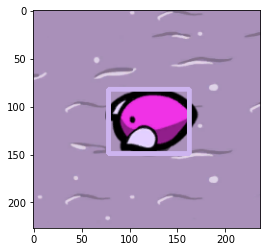

Total object count: 1
Wall time: 5.29 s


In [22]:
%%time
rcnn('test_imgs/Drone_1.png',config.filename, colors=colors)

### Class 2

pred: 2 
pred: 0 
pred: 1 


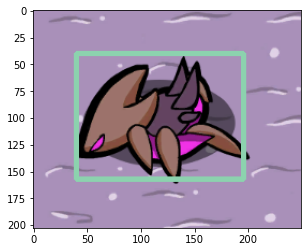

Total object count: 1
Wall time: 6.34 s


In [19]:
%%time
rcnn('test_imgs/Lurker_1.png',config.filename, colors=colors)

### Both Classes

pred: 0 
pred: 2 
pred: 1 


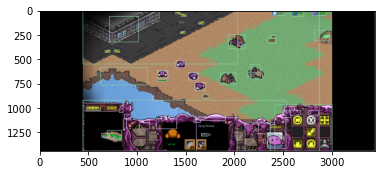

Total object count: 60
Wall time: 8min 17s


In [20]:
%%time
rcnn('test_imgs/map1.png',config.filename, colors=colors)

### Many Objects

pred: 0 
pred: 2 
pred: 1 


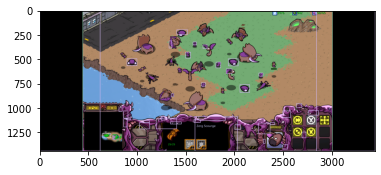

Total object count: 37
Wall time: 8min 37s


In [21]:
%%time
rcnn('test_imgs/map2.png',config.filename, colors=colors)